https://www.freecodecamp.org/news/an-intro-to-advantage-actor-critic-methods-lets-play-sonic-the-hedgehog-86d6240171d/
https://towardsdatascience.com/understanding-actor-critic-methods-931b97b6df3f
http://rail.eecs.berkeley.edu/deeprlcourse-fa17/f17docs/lecture_5_actor_critic_pdf.pdf
https://danieltakeshi.github.io/2017/03/28/going-deeper-into-reinforcement-learning-fundamentals-of-policy-gradients/
https://danieltakeshi.github.io/2018/06/28/a2c-a3c/
https://danieltakeshi.github.io/2017/04/02/notes-on-the-generalized-advantage-estimation-paper/
https://github.com/ikostrikov/pytorch-a2c-ppo-acktr-gail/blob/master/a2c_ppo_acktr/algo/a2c_acktr.py
https://github.com/higgsfield/RL-Adventure-2

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np
import gym

from utils import SubprocVecEnv

In [2]:
SEED = 1234

np.random.seed(SEED);
torch.manual_seed(SEED);

In [3]:
N_ENVS = 3

def make_env(env_name, seed):
    def _thunk():
        env = gym.make(env_name)
        env.seed(seed)
        return env
    return _thunk

#all environments need different random seed!
envs = [make_env('CartPole-v1', SEED+i) for i in range(N_ENVS)]
envs = SubprocVecEnv(envs)

env = gym.make('CartPole-v1')
env.seed(SEED)

assert isinstance(envs.observation_space, gym.spaces.Box)
assert isinstance(envs.action_space, gym.spaces.Discrete)

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout = 0.25):
        super().__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.fc_1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc_2(x)
        return x

In [5]:
INPUT_DIM = env.observation_space.shape[0]
HIDDEN_DIM = 128
OUTPUT_DIM = env.action_space.n

actor = MLP(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)
critic = MLP(INPUT_DIM, HIDDEN_DIM, 1)

In [6]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)
        
actor.apply(init_weights)
critic.apply(init_weights)

MLP(
  (fc_1): Linear(in_features=4, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.25)
)

In [7]:
LEARNING_RATE = 0.01

actor_optimizer = optim.Adam(actor.parameters(), lr = LEARNING_RATE)
critic_optimizer = optim.Adam(critic.parameters(), lr = LEARNING_RATE)

In [8]:
def train(envs, actor, critic, actor_optimizer, critic_optimizer, n_steps, discount_factor):
    
    log_prob_actions = torch.zeros(n_steps, len(envs))
    values = torch.zeros(n_steps, len(envs))
    rewards = torch.zeros(n_steps, len(envs))
    dones = torch.zeros(n_steps, len(envs))
    episode_reward = 0
    
    state = envs.get_state()
    
    for step in range(n_steps):

        state = torch.FloatTensor(state) #[n_envs, observation_space]

        action_preds = actor(state) #[n_envs, action_space]
        value_pred = critic(state).squeeze(-1) #[n_envs]
            
        action_probs = F.softmax(action_preds, dim = -1) #[n_envs, action_space]
                            
        dist = distributions.Categorical(action_probs)

        action = dist.sample() #[n_envs]
                
        log_prob_action = dist.log_prob(action) #[n_envs]
                
        #action now numpy array across all envs
        state, reward, done, _ = envs.step(action.cpu().numpy())
                
        reward = torch.FloatTensor(reward) #[n_envs]

        done = torch.FloatTensor(done) #[n_envs]
        
        log_prob_actions[step] = log_prob_action
        values[step] = value_pred
        rewards[step] = reward
        dones[step] = done
    
    next_value = critic(torch.FloatTensor(state)).squeeze(-1)
    returns = calculate_returns(rewards, next_value, dones, discount_factor)
    advantages = calculate_advantages(returns, values)
    
    policy_loss, value_loss = update_policy(advantages, log_prob_actions, returns, values, actor_optimizer, critic_optimizer)

    return policy_loss, value_loss

In [9]:
def evaluate(env, actor, critic, discount_factor):
    
    rewards = []
    done = False
    episode_reward = 0
    
    state = env.reset()
    
    while not done:
        
        state = torch.FloatTensor(state).unsqueeze(0)
        
        action_preds = actor(state)
        
        action_probs = F.softmax(action_preds, dim = -1)
        
        dist = distributions.Categorical(action_probs)

        action = dist.sample() 
        
        state, reward, done, _ = env.step(action.item())
        
        episode_reward += reward
        
    return episode_reward

In [10]:
def calculate_returns(rewards, next_value, dones, discount_factor):
    
    R = next_value
    returns = torch.zeros_like(rewards)
    
    for i, (r, d) in enumerate(zip(reversed(rewards), reversed(dones))):
        R = r + discount_factor * R * (1 - d) 
        returns[i] = R
   
    return returns

In [14]:
def calculate_advantages(returns, values, normalize = True):
    
    advantages = []
    
    for r, v in zip(reversed(returns), reversed(values)):
        advantage = r - v
        advantages.insert(0, advantage)
        
    advantages = torch.tensor(advantages)
    
    if normalize:
        
        advantages = (advantages - advantages.mean()) / advantages.std()
        
    return advantages

In [15]:
def update_policy(advantages, log_prob_actions, returns, values, actor_optimizer, critic_optimizer):
        
    policy_loss = - (advantages * log_prob_actions).mean()
    
    value_loss = F.smooth_l1_loss(returns, values).mean()
        
    actor_optimizer.zero_grad()
    critic_optimizer.zero_grad()
    
    policy_loss.backward()
    value_loss.backward()
    
    actor_optimizer.step()
    critic_optimizer.step()
    
    return policy_loss.item(), value_loss.item()

In [16]:
MAX_STEPS = 100_000
N_UPDATE_STEPS =  5
DISCOUNT_FACTOR = 0.99
N_TRIALS = 25
REWARD_THRESHOLD = 475
PRINT_EVERY = 10

episode_rewards = []

_ = envs.reset()

for step in tqdm(range(1, MAX_STEPS+1, N_UPDATE_STEPS)):
        
    policy_loss, value_loss = train(envs, actor, critic, actor_optimizer, critic_optimizer, N_UPDATE_STEPS, DISCOUNT_FACTOR)
    
    episode_reward = evaluate(env, actor, critic, DISCOUNT_FACTOR)
    
    episode_rewards.append(episode_reward)
    
    mean_trial_rewards = np.mean(episode_rewards[-N_TRIALS:])
    
    if step % (1+(N_UPDATE_STEPS*PRINT_EVERY)) == 0:
            
        print(f'| Steps: {step:6} | Mean Rewards: {mean_trial_rewards:6.2f} |')
    
    if mean_trial_rewards >= REWARD_THRESHOLD:
        
        print(f'Reached reward threshold in {episode} episodes')
        
        break

tensor([[0.9996, 0.9464, 0.9872],
        [1.9896, 1.9369, 1.9773],
        [2.9697, 2.9176, 2.9575],
        [3.9400, 3.8884, 3.9280],
        [4.9006, 4.8495, 4.8887]], grad_fn=<CopySlices>)
tensor([[ 0.0026, -0.0064,  0.0029],
        [-0.0378, -0.0356, -0.0300],
        [ 0.0037, -0.0749,  0.0056],
        [-0.0011, -0.0497, -0.0647],
        [-0.0765, -0.0007,  0.0003]], grad_fn=<CopySlices>)
torch.Size([5, 3])
torch.Size([5, 3])
tensor([[4.9771, 4.8502, 4.8884],
        [3.9411, 3.9381, 3.9926],
        [2.9660, 2.9925, 2.9519],
        [2.0274, 1.9725, 2.0073],
        [0.9970, 0.9528, 0.9842]], grad_fn=<CopySlices>)
tensor([[0.9970, 0.9528, 0.9842],
        [2.0274, 1.9725, 2.0073],
        [2.9660, 2.9925, 2.9519],
        [3.9411, 3.9381, 3.9926],
        [4.9771, 4.8502, 4.8884]], grad_fn=<SubBackward0>)



AssertionError: 

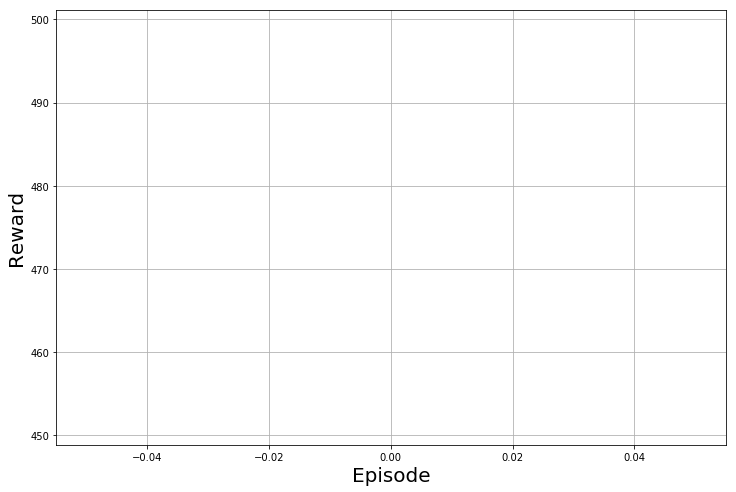

In [17]:
plt.figure(figsize=(12,8))
plt.plot(episode_rewards)
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Reward', fontsize=20)
plt.hlines(REWARD_THRESHOLD, 0, len(episode_rewards), color='r')
plt.grid()

In [ ]:
x = ['a','b','c','d','e']

for i, n in enumerate(reversed(x)):
    print(i, n)

In [ ]:
rewards = torch.randn(3,1)
print(rewards)

In [ ]:
reversed(rewards)